In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plot formatting
plt.rcParams["figure.figsize"] = (16,8)

This file contains 5000 customer queries at an online retailer, which are classified into seven topics such as "Shipping", "Product Availability", "Returns & Refunds", etc. Your job is to build a multi-class classifier that can automatically classify new incoming queries into these topics, so that they can be handled by the appropriate department.

For this assignment, select:

1. one multi-class classifier (Naive Bayes, Logistic, Decision Tree, or SVM) whose code is provided in class handouts, 

2. one ensemble classifier whose code is also provided (Random Forest or XGBoost), and 

3. one other model of your choice whose code is NOT provided in class handouts (this will require some independent research on the Internet). 

For each classifier, use three kinds of input feature vectors: 

1. TF-IDF vector, 

2. word vectors (Stanford's Glove, Google's Word2Vec, or Facebook's FastText), and 

3. document vectors (Doc2Vec). 

Train the three models using training data, report classification metrics using validation data, comment on which model will be your preferred choice for text classification for this data and why. 

Also, test your model with some (at least 5) self-created queries not in the dataset to check if your three models can classify them accurately. Submit your code and output as a Jupyter file. 

The assignment will be graded based on your ability to teach yourself a new classifier, your ability to make intelligent choices (e.g., hyper-parameters), and your ability to "communicate" your analysis in a comprehensive, understandable manner with proper documentation. Use appropriate graphics if appropriate. The professor or TA will not answer questions such as "what classification metrics should I report" or "should I do dimension reduction before using a classifier" or "what type of documentation should I include". These are choices for YOU to make (you cannot "outsource" that thinking to the professor), but your documentation must clearly describe AND EXPLAIN any choices that you make. There will be no credit for copying and pasting code from class handouts. You will be penalized for inadequate documentation; think for yourself what documentation is needed to convey what you did and why you did it to an outsider who does not know anything about this assignment.

# Source Data

In [2]:
data = pd.read_csv('Customer_Service_Questions_Multiclass.csv')
print(data.info(), '\n')
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5000 non-null   object
 1   topic     5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB
None 



,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping


# Explore Data

## Distribution of Labels

Looking at the distribution of each of the 7 query classese. The two smallest classes appear to be `Sales/Promotions` and  `OmniChannel`. We expect that our models may have a harder time trying to classify these. Also the small sample size of 5,000 may better suit ML models over other Deep-Learning models that may require larger datasets for training

Taking a closer look at the data it also appears as if some data augmentation has been used. This means more repeated words with certain variations may appear. Not a very diverse set for training could influence impact of the model

<AxesSubplot:title={'center':'Frequency of Query Categories'}, ylabel='Category'>

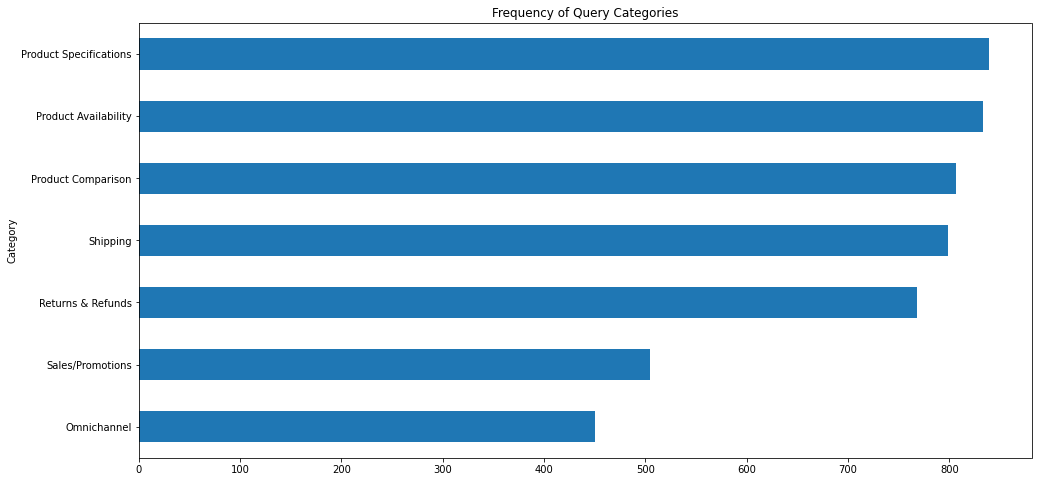

In [3]:
# See classification categfgories
data.topic.value_counts().sort_values().plot(kind='barh', title='Frequency of Query Categories', 
                                             xlabel='Category', ylabel='Frequency')

## Word Cloud per Category

In [4]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import ipywidgets as widgets


def plot_word_cloud(topic:str='Shipping'):
    # stop words for removal
    STOPWORDS = stopwords.words('english')
    # getting text for plotting filtering by topic
    text = " ".join(words for words in data[data['topic'].eq(topic)].question.tolist())
    # plotting configuration
    plt.figure(figsize=(16,8))
    wordcloud = WordCloud(background_color='white', max_words=100, stopwords=STOPWORDS).generate(text)
    plt.style.use("dark_background")
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")

widgets.interact(plot_word_cloud, topic=data.topic.unique())

interactive(children=(Dropdown(description='topic', index=1, options=('Sales/Promotions', 'Shipping', 'Product…

<function __main__.plot_word_cloud(topic: str = 'Shipping')>

It appears that there are some key words that seem to be more prevelent depending on the question topic. For example

| Topic | Common Word |
|---|---|
| Availability | Looking|
| Sale/Promo | Sale |
| Shipping | Receive |
| Specifications | Know |
| Ominchannel | Store |

# Prepare Data


Converting raw data to Textacy (Spacy) docs in batches. Loading in batches helps speed-up processing. Spacy also provides improved lemmatization, POS and dependency parsers that can be used for improved cleaning this helps expedite cleaning.

In [5]:
import textacy

"""Create Textacy Corpus for fast loading"""
# spacy library
library = 'en_core_web_sm'
# questions
questions = data.question.tolist()
# meta in dict format
topics = [{'topic':topic} for topic in data.topic.tolist()]
# create records
records = zip(questions, topics)
# create corpus
corpus = textacy.Corpus(lang=library)
# add to corpus
corpus.add_records(records=records, batch_size=50, n_process=-1)

## Cleaning
- using spacy to: remove 1) punctuations, 2) spaces, 3) spaces 4) Numeric POS 5) product codes 6) one letter from contractions (except e for email) 6) any special cases
    - removing product item codes using regex pattern

In [6]:
# Function to clean words using spacy
def clean_spacy_text(doc, exclude:list=[]):
    # patterns for removing products/website i.e. alphanumeric product item/asin dash "-", number or slash "\" for products
    pattern = re.compile(r"[a-zA-Z]+\d+[a-zA-Z\d]+|\(.+\)|\w+\-\d+/\d+|\d+[-]*|#\w+|[\w]+\-[\d]+\-[\d]+|\w+-\d+" , flags=re.IGNORECASE | re.DOTALL)
    # using list comprehensition to do a single pass cleaning
    words = [token.lemma_.lower() for token in doc if (not token.is_punct and                                   # removes punctuation
                                                       not token.is_stop and                                    # removes whitespace
                                                       not token.is_space and                                   # removes stop word
                                                       token.pos_ != 'NUM' and                                  # removes numbers
                                                       not bool(re.match(pattern, token.text.lower())) and      # removes token matches of product ids
                                                       (len(token.text) > 1 or token.text == 'e')and            # removes len text greater than 1 unless e for email
                                                       token.lemma_ not in exclude)                             # removes not in exclude list
                                                       ]
    text = ' '.join(words)
    # fix email
    text = text.replace('e mail', 'email')
    # replace missing punct at end of words i.e. word- or word\\
    text = re.sub(r"[$/_\\-]+", " ", text)
    # remove website links
    text = re.sub(r"\(?https?\S+", "", text)
    # remove single #item
    text = re.sub(r"#\S+", "", text)
    # apped to list of all docs
    return text

# # iterate through docs apply cleaning
cleaned_text = list()
for doc in corpus:
    text = clean_spacy_text(doc, exclude=[])
    cleaned_text.append(text)



# add to pandas dataframe
data['clean_question'] = cleaned_text
data.head()


,question,topic,clean_question
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,hi sign email list select email exclusively sa...
1,I'm going to be out of the country for about a...,Shipping,go country week travel go get animal print jum...
2,I was wondering if you'd be able to overnight ...,Shipping,wonder able overnight jacket item trenton nj
3,The Swingline electronic stapler (472555) look...,Shipping,swingline electronic stapler look great need s...
4,I think this cosmetic bag would work great for...,Shipping,think cosmetic bag work great know long send k...


## Encoding Label

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encoding label
encoder = LabelEncoder()
y = encoder.fit_transform(data.topic)
# train data to numpy
X = data.clean_question.to_numpy()

## Split Train-Test

Because of the small sample size and noting that there a lot of synthetic samples, it is preferrable to use a larger training size at 75%

In [8]:
from sklearn.model_selection import train_test_split

# seed for replication
seed = 42

# Splitting data
def get_data_split(X, y, test_size=.15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    if isinstance(X, list):
        X_train_size = len(X_train)
        X_test_size = len(X_test)
    else:
        X_train_size = X_train.shape[0]
        X_test_size = X_test.shape[0]
    print('Train shape X: {}, y: {}'.format(X_train_size, y_train.shape[0]))
    print('Test shape X: {}, y: {}'.format(X_test_size, y_test.shape[0]))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_data_split(X, y, test_size=0.15)

Train shape X: 4250, y: 4250
Test shape X: 750, y: 750


## TF-IDF
- settiing options to include one and bi-grams
- Setting max number of features to stop feature explosion

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

N_GRAMS = (1,3)                                         # Selecting Grams from 1-3 words
MAX_FEATURES = 5000                                     # Limiting the amount of features to help processing speed

tfidf = TfidfVectorizer(
    ngram_range=N_GRAMS,
    max_features=MAX_FEATURES)

# Fit & Preview Changes
print('Before:', X_train[0])
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print('After:\n {} \n{}'.format(X_train_tfidf[0], type(X_train_tfidf[0])))
print('Shape of X_train:', X_train_tfidf.shape)

Before: interested get sumptuous knockout mascara wonder waterproof salt water let know live near ocean want run beach
After:
   (0, 4773)	0.31765703623176056
  (0, 2132)	0.2650402074551438
  (0, 256)	0.30062724791207285
  (0, 3625)	0.24013115993458056
  (0, 4723)	0.11310998666141832
  (0, 2597)	0.24480270622493278
  (0, 2245)	0.24868244348656238
  (0, 1944)	0.11979080339388229
  (0, 2131)	0.25295738035300025
  (0, 4801)	0.24605654936208105
  (0, 3659)	0.2223709075355655
  (0, 4805)	0.25606996156736833
  (0, 4934)	0.17187577356234895
  (0, 2444)	0.2764615937077858
  (0, 4276)	0.31765703623176056
  (0, 1466)	0.20992755782584938
  (0, 1760)	0.20345313279075153 
<class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train: (4250, 5000)


## Word2Vec

Because of the smaller text size we are only using 100D per word embeddings - lower dimensionality

In [10]:
# Creating sentence -> list of tokens
def sent_tokenizer(X_data):
    X_sent_tokens = []
    for line in X_data: 
        sent = [word for word in line.split()]
        X_sent_tokens.append(sent)
    return X_sent_tokens

X_sent_tokens = sent_tokenizer(X)

# get tokens in list format
X_train, X_test, y_train, y_test = get_data_split(X_sent_tokens, y)


Train shape X: 4250, y: 4250
Test shape X: 750, y: 750


In [11]:
from gensim.models import Word2Vec

EMBEDDING_DIM = 100                                                             # Limiting the number of Embedding dimensions for relatively small dataset should be enough

# Training W2V
w2v = Word2Vec(X_train, window=8, min_count=2, sample=1e-3, sg=1, workers=8)
vocab = set(w2v.wv.index_to_key)

# Function to generate average vectors
def average_word_vectors(tokens, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    ntokens = 0.
    for t in tokens:
        if t in vocabulary: 
            ntokens = ntokens + 1.
            feature_vector = np.add(feature_vector, model.wv[t])
    if ntokens:
        feature_vector = np.divide(feature_vector, ntokens)
    return feature_vector

# Creating average 100D embeddings per token sentences 
w2v_train_x = [average_word_vectors(sent_tokens, w2v, vocab, EMBEDDING_DIM) 
               for sent_tokens in X_train]
w2v_test_x = [average_word_vectors(sent_tokens, w2v, vocab, EMBEDDING_DIM) 
              for sent_tokens in X_test]
# To Arrays
avg_w2v_train_x = np.array(w2v_train_x)              
avg_w2v_test_x = np.array(w2v_test_x)

print('Train features shape:', avg_w2v_train_x.shape, 
      '\nTest features shape:', avg_w2v_test_x.shape)

Train features shape: (4250, 100) 
Test features shape: (750, 100)


## Doc2Vec

In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Training Doc2Vec
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]
d2v = Doc2Vec(vector_size=100, window=3, min_count=4, workers=4, epochs=40)
d2v.build_vocab(docs)
d2v.train(docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)

# d2v embedded sets
d2v_train_x = [d2v.infer_vector(i) for i in X_train]
d2v_test_x =  [d2v.infer_vector(i) for i in X_test]

## Getting Datasets prepared for Modeling
Creating a master dataset dictionary to be used across models for testing

In [13]:
# Dictonary of datasets
datasets = {
    'TFIDF': {
        'train': X_train_tfidf,
        'test': X_test_tfidf
    },
    'Avg W2V Data': {
        'train': avg_w2v_train_x,
        'test': avg_w2v_test_x,
    },
    'Doc2Vector Data': {
        'train': d2v_train_x,
        'test': d2v_test_x
    }
}
# Dictionary of labels
labels = {
    'train': y_train,
    'test': y_test
}

# Models for text classification
Creating a master function that will help us evaluate the multiple models that we will be using for classification.

For our models we will be using the weighted F1-score as the main evalution to rate it's performance. This allows us to see the weighted effectiveness of our model in capturing most classes (recall) and getting our class predictions correctly (precision)

In [14]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def fit_score(model, model_name, datasets, labels):
    list_scores = list()
    models = list()
    for name, data in datasets.items():
        # getting diff model for fitting
        model = clone(model)
        print(f'Dataset: {name}')
        # fit model
        model.fit(data['train'], labels['train'])
        # cross-validate score
        cross_val = cross_val_score(model, X=data['train'], y=labels['train'], scoring='f1_weighted')
        print(f'CV Weighted F1-Scores: {cross_val}')
        print('Avg CV Score: {}'.format(np.mean(cross_val)))
        # predict
        y_predict = model.predict(data['test'])
        # classification report
        target_names = encoder.classes_
        # print report
        print(classification_report(labels['test'], y_predict, target_names=target_names))
        # soring function to iterate
        scores_functions = {'Precision':precision_score, 'Recall':recall_score, 'F1 Score': f1_score}
        # dictionary for model
        model_scores = {'Model': model_name, 'Dataset': name}
        # add scores
        for name, function in scores_functions.items():
            score = function(y_predict, labels['test'], average='weighted')
            model_scores[name] = score
        # insert into list of scores
        list_scores.append(model_scores)
        models.append(model)
    return models, list_scores

## SVM (LinearSVC)

In [15]:
from sklearn.svm import LinearSVC

# Initiating simple mode
svc = LinearSVC()

# Fitting and Scoring
[svc_tfidf, svc_w2v, svc_d2v], scores = fit_score(svc, 'SV Classifier', datasets, labels)


Dataset: TFIDF
CV Weighted F1-Scores: [0.94716739 0.9423865  0.95523986 0.94807148 0.94356655]
Avg CV Score: 0.9472863561949751
                        precision    recall  f1-score   support

           Omnichannel       1.00      1.00      1.00        68
  Product Availability       0.93      0.95      0.94       131
    Product Comparison       0.90      0.92      0.91       113
Product Specifications       0.91      0.91      0.91       117
     Returns & Refunds       0.99      1.00      1.00       124
      Sales/Promotions       1.00      0.94      0.97        82
              Shipping       1.00      1.00      1.00       115

              accuracy                           0.96       750
             macro avg       0.96      0.96      0.96       750
          weighted avg       0.96      0.96      0.96       750

Dataset: Avg W2V Data
CV Weighted F1-Scores: [0.839214   0.85561033 0.84137026 0.85069685 0.82721351]
Avg CV Score: 0.8428209899624791
                        precis

SVC appears to do pretty well in classification of document types especially when using the TFIDF method. I believe that the embedding that we attempted had too small of a data sample to be able to be trained properly. I tried to do transfer learning approaches but did not have a clear understanding of how to use them in gensim. The function (intersect_word2vec_format) that use to exist for this appeard to not be working in my latest version

In [16]:
# Display SVC Scores
pd.DataFrame(scores).sort_values('F1 Score', ascending=False)

,Model,Dataset,Precision,Recall,F1 Score
0,SV Classifier,TFIDF,0.957385,0.957333,0.957238
1,SV Classifier,Avg W2V Data,0.885674,0.881333,0.882211
2,SV Classifier,Doc2Vector Data,0.566537,0.560000,0.561100


## RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

# Fitting and Scoring
[rfc_tfidf, rfc_w2v, rfc_d2v], rfc_scores = fit_score(rfc, 'RF Classifier', datasets, labels)

# adding rfc scores to scores
scores.extend(rfc_scores)


Dataset: TFIDF
CV Weighted F1-Scores: [0.93184506 0.94563494 0.94249841 0.94816488 0.93583199]
Avg CV Score: 0.9407950552169991
                        precision    recall  f1-score   support

           Omnichannel       0.99      0.97      0.98        68
  Product Availability       0.93      0.98      0.96       131
    Product Comparison       0.93      0.94      0.93       113
Product Specifications       0.93      0.91      0.92       117
     Returns & Refunds       0.98      1.00      0.99       124
      Sales/Promotions       1.00      0.93      0.96        82
              Shipping       1.00      0.99      1.00       115

              accuracy                           0.96       750
             macro avg       0.97      0.96      0.96       750
          weighted avg       0.96      0.96      0.96       750

Dataset: Avg W2V Data
CV Weighted F1-Scores: [0.90034004 0.91953115 0.90127875 0.90495221 0.88368582]
Avg CV Score: 0.9019575945526329
                        precis

It appears that the RF Classifier performs better in comparison to the SV Classifier across all dataset. The difference in performance is more noticeable in the two embedded datasets, but only slight (F1 = +.04%) for the TfiDf dataset.

In [18]:
# Displaying top candidates
pd.DataFrame(scores).sort_values('F1 Score', ascending=False)

,Model,Dataset,Precision,Recall,F1 Score
3,RF Classifier,TFIDF,0.962100,0.961333,0.961376
0,SV Classifier,TFIDF,0.957385,0.957333,0.957238
4,RF Classifier,Avg W2V Data,0.923030,0.922667,0.922724
1,SV Classifier,Avg W2V Data,0.885674,0.881333,0.882211
5,RF Classifier,Doc2Vector Data,0.750537,0.745333,0.745267
2,SV Classifier,Doc2Vector Data,0.566537,0.560000,0.561100


## TF Keras Deep Learning 

### Deep Learning Model

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

def deep_learner_classifier(classes:int, dropout_p:float, activation:str, input_shape:tuple):
    """Basic Deep Learner Classifer for text

    Args:
        classes (int): number of classes to predict
        dropout_p (float): percentage of drop out per each layer
        activation (str): type of activation function to be used per layer
        input_shape (tuple): shape of the input for the first layer

    Returns:
        tf.keras.models.Sequential: a model compiled for fitting
    """
    model = Sequential()
    model.add(Dense(1024, input_shape=input_shape))
    model.add(Activation(activation))
    model.add(Dropout(dropout_p))
    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(dropout_p))
    model.add(Dense(64))
    model.add(Activation(activation))
    model.add(Dropout(dropout_p))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### General Parameters & Encoding Labels

Setting general params that can be used accross models

In [20]:
# Setting Parameters
CLASSES = len(encoder.classes_)
BATCH_SIZE = 64
DROPOUT = 0.1
ACTIVATION = 'relu'

# Crating One-Hot Econders for Categories
y_train_tf = np_utils.to_categorical(y_train, CLASSES)
y_test_tf = np_utils.to_categorical(y_test, CLASSES)


### Scoring Function

In [21]:
def score_deep_learner(model, X_test, model_name, data_name):
    # true labels
    y_true = [np.argmax(arr) for arr in y_test_tf]
    # predict
    y_predict = [np.argmax(arr) for arr in model.predict(X_test)]
    # classification report
    target_names = encoder.classes_
    # print report
    print(classification_report(y_true, y_predict, target_names=target_names))
    # soring function to iterate
    scores_functions = {'Precision':precision_score, 'Recall':recall_score, 'F1 Score': f1_score}
    # dictionary for model
    model_scores = {'Model': model_name, 'Dataset': data_name}
    # add scores
    for name, function in scores_functions.items():
        score = function(y_predict, y_true, average='weighted')
        model_scores[name] = score
    return model_scores


### TFIDF Deep Learner

In [22]:
# Params for TFIDF
INPUT_SHAPE = (5000,)                                           # Matching the size of the vocab vectors
EPOCHS = 5                                                      # Limiting amount of epochs for trial

# Initializing model
tfidf_dl = deep_learner_classifier(classes=CLASSES, dropout_p=DROPOUT, activation=ACTIVATION, input_shape=INPUT_SHAPE)

# Fitting
tfidf_dl.fit(X_train_tfidf.toarray(), y_train_tf, validation_data=(X_test_tfidf.toarray(), y_test_tf), batch_size=BATCH_SIZE, epochs=EPOCHS)

# Score
tfidf_dl_score = score_deep_learner(tfidf_dl, X_test_tfidf.toarray(), 'Deep Learner', 'TFIDF')


2021-10-17 23:07:25.988234: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 23:07:26.593309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
67/67 [==============================] - 3s 29ms/step - loss: 0.7674 - accuracy: 0.7696 - val_loss: 0.1748 - val_accuracy: 0.9387
Epoch 2/5
67/67 [==============================] - 2s 26ms/step - loss: 0.0900 - accuracy: 0.9734 - val_loss: 0.1212 - val_accuracy: 0.9587
Epoch 3/5
67/67 [==============================] - 2s 34ms/step - loss: 0.0326 - accuracy: 0.9904 - val_loss: 0.1342 - val_accuracy: 0.9653
Epoch 4/5
67/67 [==============================] - 3s 40ms/step - loss: 0.0167 - accuracy: 0.9960 - val_loss: 0.1476 - val_accuracy: 0.9547
Epoch 5/5
67/67 [==============================] - 2s 32ms/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.1298 - val_accuracy: 0.9640
                        precision    recall  f1-score   support

           Omnichannel       1.00      1.00      1.00        68
  Product Availability       0.92      0.98      0.95       131
    Product Comparison       0.93      0.91      0.92       113
Product Specifications       0.93      0.91

### Avg. Word2Vec Deep Learner

In [23]:
# Params for Avg Word2Vec
INPUT_SHAPE = (100,)                                                            # Matching the size of the embedded vectors
EPOCHS = 5                                                                      # Number of training epochs limited as very little validation loss experienced before signs of overfitting in training

# Initializing model
w2v_dl = deep_learner_classifier(classes=CLASSES, dropout_p=DROPOUT, activation=ACTIVATION, input_shape=INPUT_SHAPE)


# Fitting
w2v_dl.fit(avg_w2v_train_x, y_train_tf, validation_data=(avg_w2v_test_x, y_test_tf), batch_size=BATCH_SIZE, epochs=EPOCHS)

# Score
w2v_dl_score = score_deep_learner(w2v_dl, avg_w2v_test_x, 'Deep Learner', 'Avg W2V Data')

Epoch 1/5
67/67 [==============================] - 1s 9ms/step - loss: 0.7904 - accuracy: 0.7096 - val_loss: 0.4563 - val_accuracy: 0.7933
Epoch 2/5
67/67 [==============================] - 0s 6ms/step - loss: 0.4968 - accuracy: 0.7899 - val_loss: 0.4195 - val_accuracy: 0.8147
Epoch 3/5
67/67 [==============================] - 1s 8ms/step - loss: 0.4347 - accuracy: 0.8054 - val_loss: 0.3962 - val_accuracy: 0.8253
Epoch 4/5
67/67 [==============================] - 0s 6ms/step - loss: 0.3947 - accuracy: 0.8308 - val_loss: 0.3769 - val_accuracy: 0.8373
Epoch 5/5
67/67 [==============================] - 0s 6ms/step - loss: 0.3852 - accuracy: 0.8313 - val_loss: 0.3702 - val_accuracy: 0.8227
                        precision    recall  f1-score   support

           Omnichannel       0.90      0.96      0.93        68
  Product Availability       0.85      0.89      0.87       131
    Product Comparison       0.53      0.90      0.67       113
Product Specifications       0.87      0.22     

### Doc2Vec Deep Learner

In [24]:
# Params for Doc2Vec
INPUT_SHAPE = (100,)                                                            # Matching the size of the embedded vectors
EPOCHS = 5                                                                      # Number of training epochs limited as very little validation loss experienced before signs of overfitting in training

# Initializing model
d2v_dl = deep_learner_classifier(classes=CLASSES, dropout_p=DROPOUT, activation=ACTIVATION, input_shape=INPUT_SHAPE)


# Fitting
d2v_dl.fit(np.array(d2v_train_x), y_train_tf, validation_data=(np.array(d2v_test_x), y_test_tf), batch_size=BATCH_SIZE, epochs=EPOCHS)

# Score
d2v_dl_score = score_deep_learner(w2v_dl, np.array(d2v_test_x), 'Deep Learner', 'Doc2Vector Data')

Epoch 1/5
67/67 [==============================] - 1s 11ms/step - loss: 1.5117 - accuracy: 0.4261 - val_loss: 1.2299 - val_accuracy: 0.5573
Epoch 2/5
67/67 [==============================] - 0s 6ms/step - loss: 1.0930 - accuracy: 0.6115 - val_loss: 1.0712 - val_accuracy: 0.6253
Epoch 3/5
67/67 [==============================] - 1s 8ms/step - loss: 0.8718 - accuracy: 0.7075 - val_loss: 0.9523 - val_accuracy: 0.6693
Epoch 4/5
67/67 [==============================] - 0s 6ms/step - loss: 0.7024 - accuracy: 0.7664 - val_loss: 0.8269 - val_accuracy: 0.7307
Epoch 5/5
67/67 [==============================] - 1s 8ms/step - loss: 0.5565 - accuracy: 0.8174 - val_loss: 0.8404 - val_accuracy: 0.7347
                        precision    recall  f1-score   support

           Omnichannel       0.33      0.29      0.31        68
  Product Availability       0.35      0.50      0.41       131
    Product Comparison       0.23      0.46      0.30       113
Product Specifications       0.33      0.12    

It appears that out of all the Deep Learning models attempted the one with the TFIDF data appears to perform best in comparison to the W2V and D2V models by 10-20% more

In [25]:
# Appending DL Scores 
scores.append(tfidf_dl_score)
scores.append(w2v_dl_score)
scores.append(d2v_dl_score)

scores_df = pd.DataFrame(scores)

# Evaluation
While the Deep Learner and Random Forest Classifier performed best, out of the three models and data transformations attempted for text classification, I would pick the SVC with TfiDf simply because it provides only slightly smaller f1-score (0.07%) than the next best model while providing the most simplicity. This makes this model easier to undestand, avoids overfitting and provides faster performance.

In [26]:
scores_df.sort_values('F1 Score', ascending=False)

,Model,Dataset,Precision,Recall,F1 Score
6,Deep Learner,TFIDF,0.964689,0.964000,0.964050
3,RF Classifier,TFIDF,0.962100,0.961333,0.961376
0,SV Classifier,TFIDF,0.957385,0.957333,0.957238
4,RF Classifier,Avg W2V Data,0.923030,0.922667,0.922724
1,SV Classifier,Avg W2V Data,0.885674,0.881333,0.882211
7,Deep Learner,Avg W2V Data,0.902260,0.822667,0.842001
5,RF Classifier,Doc2Vector Data,0.750537,0.745333,0.745267
2,SV Classifier,Doc2Vector Data,0.566537,0.560000,0.561100
8,Deep Learner,Doc2Vector Data,0.387774,0.317333,0.329950


# Out-of-Sample Evaluation

In [27]:
import spacy
# Create pipeline func for cleaning tfidf, word2vec, doc2vec
def predict_pipeline(model, data, labels, transformation, deep_learner=False):
    # convert to spacy and clean
    nlp = spacy.load(library)
    docs = [clean_spacy_text(nlp(text)) for text in data]
    # transformation type
    if transformation == 'tfidf':
        docs = tfidf.transform(docs)
    if transformation == 'word2vec':
        docs = sent_tokenizer(docs)
        docs = [average_word_vectors(doc, w2v, vocab, EMBEDDING_DIM) for doc in docs]
    if transformation == 'doc2vec':
        docs = sent_tokenizer(docs)
        docs = [d2v.infer_vector(doc) for doc in docs]
    # make predictions
    if deep_learner:
        if transformation == 'tfidf':
            docs = docs.toarray()
        if transformation == 'doc2vec':
            docs = np.array(docs)
        predictions = [np.array(np.argmax(arr)) for arr in model.predict(docs)]
    else:
        predictions = model.predict(docs)
    print('Actual --> Predicted')
    for i, pred in enumerate(predictions):
        print("['{1}'] --> {0}".format(encoder.inverse_transform(pred.ravel()), labels[i]))


In [30]:
text1 = "Hello, I was wondering if you are able to provide expedite shipping for item (9292323) to Tampa, FL?" # --> Shipping
text2 = "The polo shirt that I received is size small instead of the medium I ordered. Can you send me a return label? I should not have to pay for this either." #--> Returns
text3 = "Are there any promo codes available for products in your gaming and entertaiment?" #--> Sales/Promotions
text4 = "Do you have any men's pants that I could buy? I really liked the last ones I purchased." #--> Product Availability
text5 = "How long does the battery for the IPhone 13 last? I am looking to upgrade my phone." #--> Product Specification
oos_test = [text1, text2, text3, text4, text5]
class_labels = ['Shipping', 'Returns & Refunds', 'Sales/Promotions', 'Product Availability', 'Product Specification']


# Compare Predictions
print('SVC - TFIDF')
predict_pipeline(svc_tfidf, oos_test, class_labels, transformation='tfidf')
print('\nRFC - TFIDF')
predict_pipeline(rfc_tfidf, oos_test, class_labels, transformation='tfidf')
print('\nDeep Learner - TFIDF')
predict_pipeline(tfidf_dl, oos_test, class_labels, transformation='tfidf', deep_learner=True)


SVC - TFIDF
Actual --> Predicted
['Shipping'] --> ['Shipping']
['Returns & Refunds'] --> ['Returns & Refunds']
['Sales/Promotions'] --> ['Sales/Promotions']
['Product Availability'] --> ['Product Availability']
['Product Specification'] --> ['Product Availability']

RFC - TFIDF
Actual --> Predicted
['Shipping'] --> ['Shipping']
['Returns & Refunds'] --> ['Returns & Refunds']
['Sales/Promotions'] --> ['Sales/Promotions']
['Product Availability'] --> ['Product Availability']
['Product Specification'] --> ['Product Availability']

Deep Learner - TFIDF
Actual --> Predicted
['Shipping'] --> ['Shipping']
['Returns & Refunds'] --> ['Returns & Refunds']
['Sales/Promotions'] --> ['Sales/Promotions']
['Product Availability'] --> ['Product Availability']
['Product Specification'] --> ['Product Availability']


It appears that SVC, RFC and Deep Learner with TFIDF are able to correctly classify 4/5 out of the five samples. They all faill to classify the last query meant for Product Specifications. I imagine that the second phrase with the word I am looking is probabily throwing off this prediction. To improve from this error pre-trained embeddings could be used in transfer learning along with RNN models that may be able to pick up that both sentences refer to the same item and the question is referring to the real interest for the customer. This should also be noted and potentially question marks should not be deleted from cleaning